In [3]:
import os
from glob import glob
import matplotlib.pyplot as plt
import random
import cv2
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns
import zlib
import itertools
import sklearn
import itertools
import scipy
import skimage
from skimage.transform import resize
import csv
from tqdm import tqdm
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve,KFold,cross_val_score,StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
import keras
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import backend as K
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
#from keras.applications.mobilenet import MobileNet
#from sklearn.metrics import roc_auc_score
#from sklearn.metrics import roc_curve
#from sklearn.metrics import auc
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [4]:
imageSize=224
train_dir = "OCT2017/train/"
test_dir =  "OCT2017/test/"
# ['DME', 'CNV', 'NORMAL', '.DS_Store', 'DRUSEN']
from tqdm import tqdm
def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['NORMAL']:
                label = 0
            elif folderName in ['CNV']:
                label = 1
            elif folderName in ['DME']:
                label = 2
            elif folderName in ['DRUSEN']:
                label = 3
            else:
                label = 4
            for image_filename in tqdm(os.listdir(folder + folderName)):
                img_file = cv2.imread(folder + folderName + '/' + image_filename)
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (imageSize, imageSize, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y
#X_train, y_train = get_data(train_dir) # Un-comment to use full dataset: Step 1 of 2
X_test, y_test= get_data(test_dir)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_test, y_test, test_size=0.2) # Re-comment to use full dataset: Step 2 of 2

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from tensorflow.keras.utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes = 4)
y_testHot = to_categorical(y_test, num_classes = 4)

100%|██████████| 242/242 [00:07<00:00, 31.02it/s]


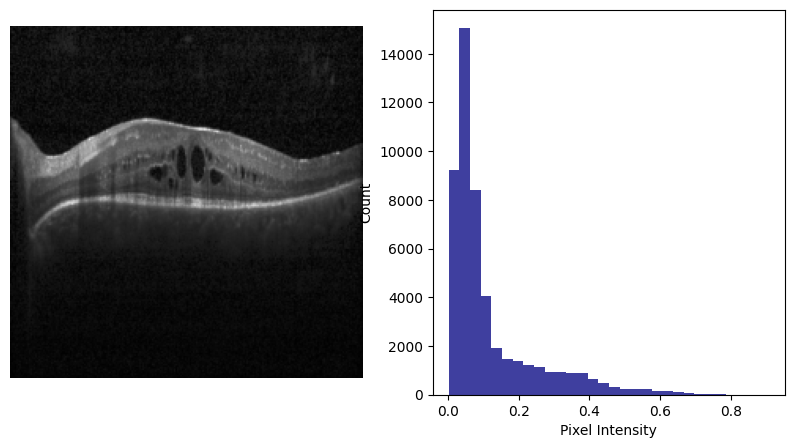

In [5]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
plotHistogram(X_train[1])

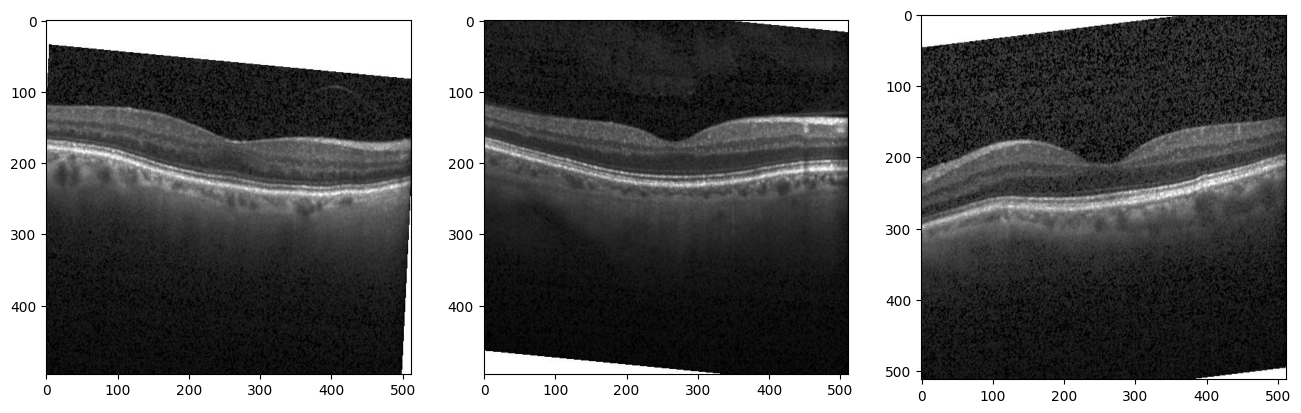

In [6]:
multipleImages = glob('OCT2017/train/NORMAL/**')
def plotThreeImages(images):
    r = random.sample(images, 3)
    plt.figure(figsize=(16,16))
    plt.subplot(131)
    plt.imshow(cv2.imread(r[0]))
    plt.subplot(132)
    plt.imshow(cv2.imread(r[1]))
    plt.subplot(133)
    plt.imshow(cv2.imread(r[2])); 
plotThreeImages(multipleImages)

Normal


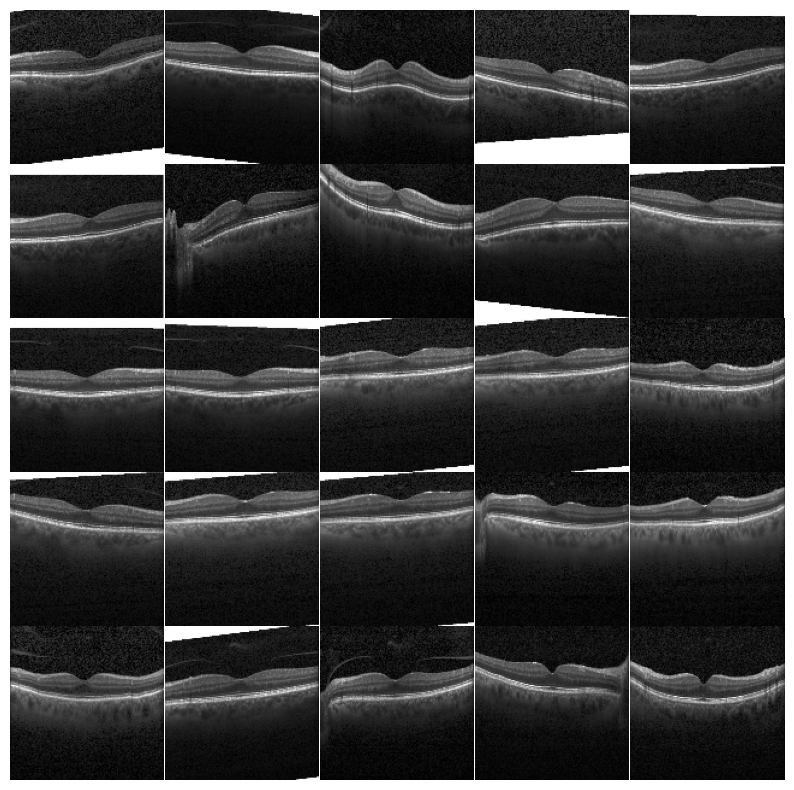

In [7]:
print("Normal")
multipleImages = glob('OCT2017/train/NORMAL/**')
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

CNV


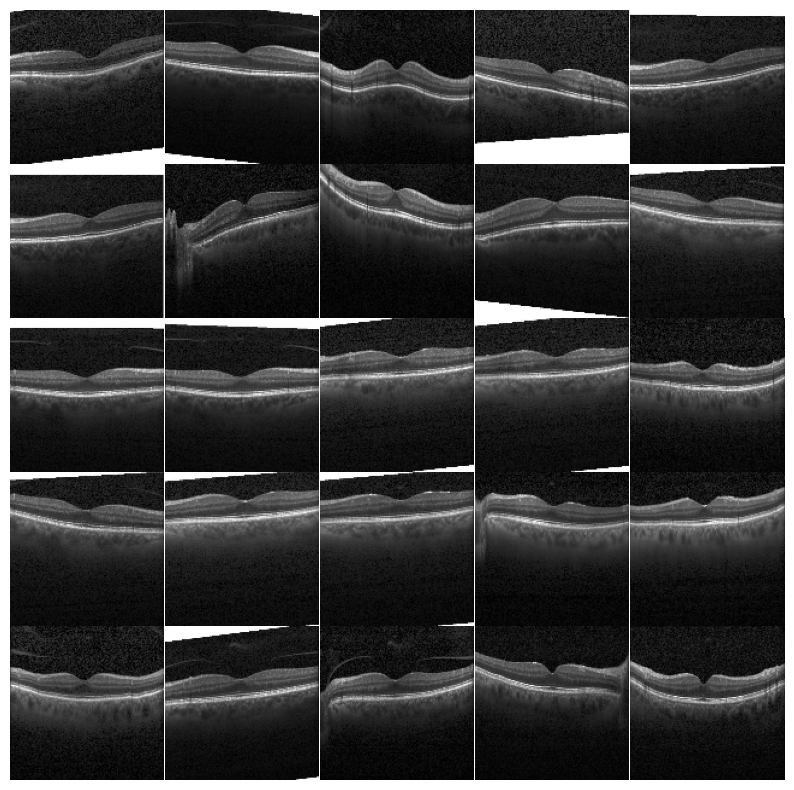

In [8]:
print("CNV")
multipleImages = glob('OCT2017/train/NORMAL/**')
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

DME


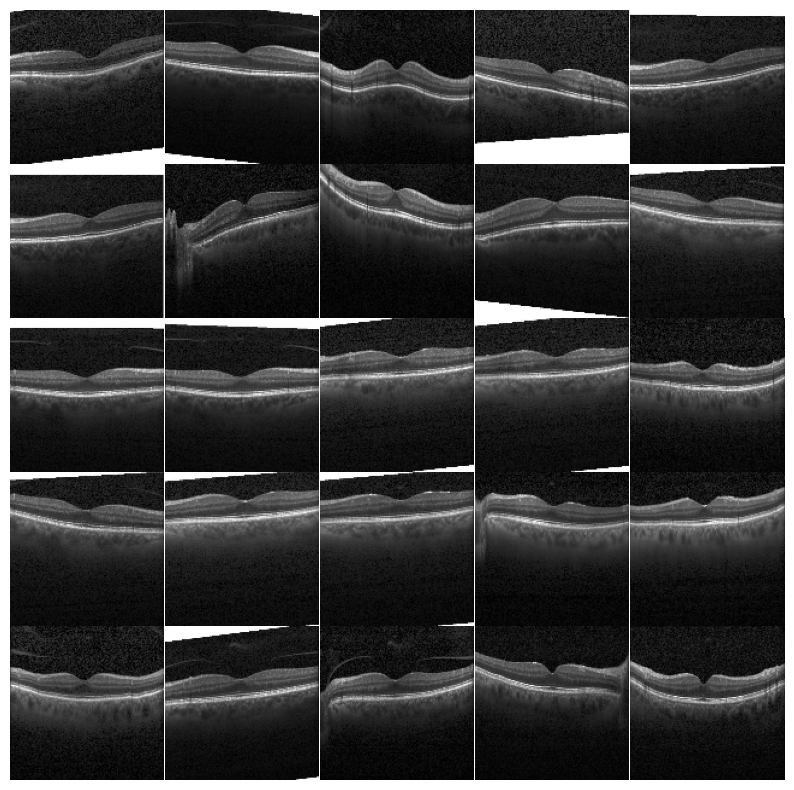

In [9]:
print("DME")
multipleImages = glob('OCT2017/train/NORMAL/**')
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

In [10]:
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from keras.applications import VGG16, InceptionV3
from keras.models import Model
from keras.layers import Conv2D, Flatten, Dropout, Dense
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from keras.optimizers import Adam, RMSprop

# Define label map
map_characters1 = {0: 'Normal', 1: 'CNV', 2: 'DME', 3: 'DRUSEN'}

# Compute class weights (✅ Use keyword arguments only)
class_weight1 = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Use ImageNet weights directly
pretrained_model_1 = VGG16(weights='imagenet', include_top=False, input_shape=(imageSize, imageSize, 3))
pretrained_model_2 = InceptionV3(weights='imagenet', include_top=False, input_shape=(imageSize, imageSize, 3))

# Define optimizers
optimizer1 = Adam()
optimizer2 = RMSprop(learning_rate=0.00005)  # ✅ lr is deprecated

# Main model-building and training function
def pretrainedNetwork(xtrain, ytrain, xtest, ytest,
                      base_model, class_weight, num_classes,
                      num_epochs, optimizer, labels, batch_size=32):
    
    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom top layers
    x = base_model.output
    x = Conv2D(256, kernel_size=(3, 3), padding='valid', activation='relu')(x)
    x = Flatten()(x)
    x = Dropout(0.75)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile model
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )

    # Define callbacks (✅ update monitor name)
    callbacks_list = [
        EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, restore_best_weights=True)
    ]

    # Fit model
    history = model.fit(
        xtrain, ytrain,
        epochs=num_epochs,
        batch_size=batch_size,
        class_weight=dict(enumerate(class_weight)),
        validation_data=(xtest, ytest),
        verbose=1,
        callbacks=callbacks_list
    )

    # Evaluate model
    score = model.evaluate(xtest, ytest, verbose=0)
    print('\nTest Accuracy:', score[1])

    # Generate predictions
    y_pred = model.predict(xtest)
    print('\nClassification Report:\n',
          classification_report(np.argmax(ytest, axis=1),
                                np.argmax(y_pred, axis=1),
                                target_names=list(labels.values())))

    # Confusion Matrix
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(ytest, axis=1)
    cm = confusion_matrix(y_true, y_pred_classes)

    


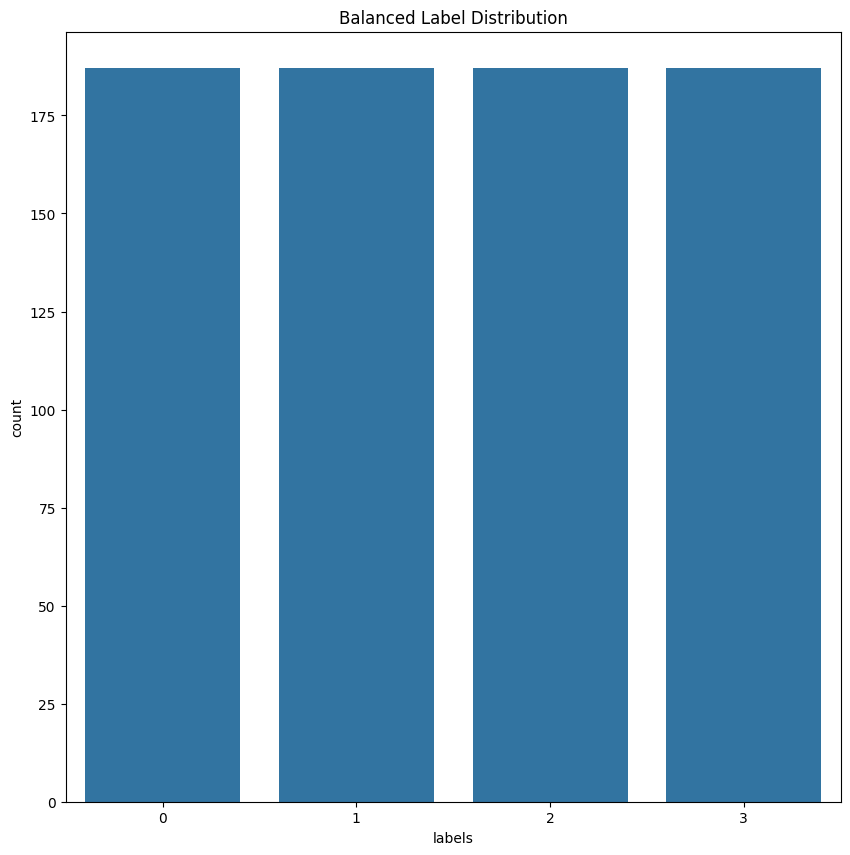

{0: 'Normal', 1: 'CNV', 2: 'DME', 3: 'DRUSEN'}


In [14]:
from sklearn.utils import shuffle
map_characters1 = {0: 'Normal', 1: 'CNV', 2: 'DME', 3: 'DRUSEN'}

# Flatten image data for resampling
X_trainShape = X_train.shape[1] * X_train.shape[2] * X_train.shape[3]
X_testShape = X_test.shape[1] * X_test.shape[2] * X_test.shape[3]

X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)

Y_train = y_train
Y_test = y_test

# Use updated correct parameter: sampling_strategy instead of ratio
ros = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Fit and resample
X_trainRos, Y_trainRos = ros.fit_resample(X_trainFlat, Y_train)
X_testRos, Y_testRos = ros.fit_resample(X_testFlat, Y_test)

# One-hot encode labels
Y_trainRosHot = to_categorical(Y_trainRos, num_classes=4)
Y_testRosHot = to_categorical(Y_testRos, num_classes=4)

# Reshape back to image dimensions (4D)
X_trainRosReshaped = X_trainRos.reshape(-1, imageSize, imageSize, 3)
X_testRosReshaped = X_testRos.reshape(-1, imageSize, imageSize, 3)

# Optional: Shuffle the data for training
X_trainRosReshaped, Y_trainRosHot = shuffle(X_trainRosReshaped, Y_trainRosHot, random_state=42)

# Plot label distribution
dfRos = pd.DataFrame()
dfRos["labels"] = Y_trainRos
sns.countplot(x="labels", data=dfRos)
plt.title("Balanced Label Distribution")
plt.show()

# Print label mapping
print(map_characters1)

In [15]:
from sklearn.utils.class_weight import compute_class_weight

class_weight1 = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(Y_train),
    y=Y_train
)

class_weight2 = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(Y_trainRos),
    y=Y_trainRos
)


In [16]:
from sklearn.utils import shuffle
X_trainRosReshaped, Y_trainRosHot = shuffle(X_trainRosReshaped, Y_trainRosHot, random_state=13)
X_testRosReshaped, Y_testRosHot = shuffle(X_testRosReshaped, Y_testRosHot, random_state=13)

In [17]:
from sklearn.utils.class_weight import compute_class_weight

class_weight1 = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(Y_train),
    y=Y_train
)

class_weight2 = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(Y_trainRos),
    y=Y_trainRos
)

print("Old Class Weights:", class_weight1)
print("New Class Weights:", class_weight2)


Old Class Weights: [0.99230769 0.97236181 1.00259067 1.03475936]
New Class Weights: [1. 1. 1. 1.]


In [18]:
# Shuffle data to permit further subsampling
from sklearn.utils import shuffle
X_trainRosReshaped, Y_trainRosHot = shuffle(X_trainRosReshaped, Y_trainRosHot, random_state=13)
X_testRosReshaped, Y_testRosHot = shuffle(X_testRosReshaped, Y_testRosHot, random_state=13)

In [19]:
model = pretrainedNetwork(
    X_trainRosReshaped[:10000], Y_trainRosHot[:10000],
    X_testRosReshaped[:2000], Y_testRosHot[:2000],
    pretrained_model_1,
    class_weight2,
    4,              # number of classes
    50,             # number of epochs
    optimizer1,
    map_characters1,
    128   
)          


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 141s 23s/step - accuracy: 0.2840 - loss: 1.9113 - val_accuracy: 0.6279 - val_loss: 1.0218
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 147s 25s/step - accuracy: 0.5797 - loss: 1.0135 - val_accuracy: 0.7674 - val_loss: 0.7631
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 161s 29s/step - accuracy: 0.7128 - loss: 0.7135 - val_accuracy: 0.7965 - val_loss: 0.5455
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 205s 35s/step - accuracy: 0.8007 - loss: 0.5126 - val_accuracy: 0.7849 - val_loss: 0.4924
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 187s 32s/step - accuracy: 0.8329 - loss: 0.4488 - val_accuracy: 0.8314 - val_loss: 0.4252
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 182s 32s/step - accuracy: 0.8800 - loss: 0.3442 - val_accuracy: 0.8372 - val_loss: 0.3940
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 199s 31s/step - accuracy: 0.9034 - loss: 0.2789 - val_accuracy: 0.8663 - val_loss: 0.3355
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 184s 32s/step - accuracy: 0.9023 - loss: 0.2524 - val_accuracy: 0.8837 - val_loss:

In [35]:
def pretrainedNetwork(xtrain, ytrain, xtest, ytest,
                      base_model, class_weight, num_classes,
                      num_epochs, optimizer, labels, batch_size=32):
    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers
    x = base_model.output
    x = Conv2D(256, kernel_size=(3, 3), padding='valid', activation='relu')(x)
    x = Flatten()(x)
    x = Dropout(0.75)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    # Train model
    callbacks_list = [
        EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
    ]
    history = model.fit(
        xtrain, ytrain,
        validation_data=(xtest, ytest),
        epochs=num_epochs,
        batch_size=batch_size,
        class_weight=dict(enumerate(class_weight)),
        callbacks=callbacks_list,
        verbose=1
    )

    # Evaluation
    y_pred = model.predict(xtest)
    confusion_mtx = confusion_matrix(np.argmax(ytest, axis=1), np.argmax(y_pred, axis=1))
    print("Classification Report:\n", classification_report(
        np.argmax(ytest, axis=1),
        np.argmax(y_pred, axis=1),
        target_names=list(labels.values())
    ))

    return model, history, confusion_mtx  # ✅ Make sure this is inside the function


In [39]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)  # ✅ enables eager execution


In [40]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Flatten, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

def pretrainedNetwork(xtrain, ytrain, xtest, ytest,
                      base_model, class_weight, num_classes,
                      num_epochs, optimizer, labels, batch_size=32):
    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom top layers
    x = base_model.output
    x = Conv2D(256, (3, 3), padding='valid', activation='relu')(x)
    x = Flatten()(x)
    x = Dropout(0.75)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )

    # Train the model
    callbacks_list = [
        EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
    ]

    history = model.fit(
        xtrain, ytrain,
        validation_data=(xtest, ytest),
        epochs=num_epochs,
        batch_size=batch_size,
        class_weight=dict(enumerate(class_weight)),
        callbacks=callbacks_list,
        verbose=1
    )

    # Predictions
    y_pred = model.predict(xtest)
    try:
        y_pred = y_pred.numpy()  # ✅ Convert to NumPy if it's a Tensor
    except:
        pass

    y_true = np.argmax(ytest, axis=1)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Evaluation
    confusion_mtx = confusion_matrix(y_true, y_pred_classes)
    print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=list(labels.values())))

    return model, history, confusion_mtx


In [42]:
from tensorflow.keras.optimizers import Adam

model, history, confusion_mtx = pretrainedNetwork(
    X_trainRosReshaped[:10000], Y_trainRosHot[:10000],
    X_testRosReshaped[:2000], Y_testRosHot[:2000],
    pretrained_model_1,
    class_weight2,
    4,
    5,
    Adam(),  # ✅ Fresh instance here
    map_characters1,
    128
)


Epoch 1/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 950s 156s/step - accuracy: 0.3141 - loss: 2.0359 - val_accuracy: 0.6570 - val_loss: 1.0462
Epoch 2/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 885s 148s/step - accuracy: 0.5712 - loss: 1.0373 - val_accuracy: 0.7442 - val_loss: 0.7854
Epoch 3/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 746s 119s/step - accuracy: 0.6762 - loss: 0.7834 - val_accuracy: 0.7733 - val_loss: 0.5846
Epoch 4/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 757s 132s/step - accuracy: 0.8051 - loss: 0.5535 - val_accuracy: 0.8372 - val_loss: 0.5008
Epoch 5/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 785s 134s/step - accuracy: 0.8262 - loss: 0.4796 - val_accuracy: 0.8488 - val_loss: 0.4350
6/6 ━━━━━━━━━━━━━━━━━━━━ 39s 6s/step
Classification Report:
               precision    recall  f1-score   support

      Normal       0.76      0.98      0.86        43
         CNV       0.84      0.88      0.86        43
         DME       0.94      0.72      0.82        43
      DRUSEN       0.90      0.81      0.85        43

    accuracy                         

In [5]:
model.save("retina_oct_model.keras")  # Modern format


In [6]:
from keras.models import load_model

# Step 1: Load the existing .keras model
model = load_model("retina_oct_model.keras")

# Step 2: Save as legacy .h5 format
model.save("retina_oct_model.h5")
print("✅ Model converted and saved as retina_oct_model.h5")


c:\Users\LENOVO\Desktop\Research\tf_311\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


✅ Model converted and saved as retina_oct_model.h5


In [7]:
from keras.models import load_model

# Load using current environment
model = load_model("retina_oct_model.keras")  # Or .h5

# Save in legacy-compatible format
model.save("retina_oct_model_legacy.h5", save_format="h5")


In [8]:
from tensorflow.keras.models import load_model

model = load_model("retina_oct_model.keras")  # Load in Keras 3 environment
model.save("retina_oct_model_legacy.h5")      # Save in backward-compatible format
